# ----------------- PROCESO 3: Data Modeling --------------------------------

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


### Importamos las librerias que utilizaremos

In [9]:
#instantiate Logistic Regression and get up and running by the end of the day
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

##Para redes neuronales usaremos Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

#Para modelos estadísticos
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, r2_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm_notebook
from catboost import CatBoostClassifier
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

### Read in CSV

In [10]:
data_read = pd.read_csv('./Total_Cleaned_Data_for_Data_Modeling.csv')

In [11]:
data = data_read

In [12]:
#Se trata de un problema de Clasificacion Binaria
data['classes'].value_counts()

1    952938
0    257968
Name: classes, dtype: int64

In [13]:
num_cols = data.select_dtypes(include=('int64', 'float64')).columns

In [14]:
list(num_cols)

['loan_amnt',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mort_acc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_il_high_credit_limit',
 'classes',
 

In [15]:
data.dtypes.value_counts()

int64      85
float64    71
object      5
dtype: int64

## Definiendo las entradas

In [16]:
X = data[num_cols].drop(columns='classes')
y = data['classes']

In [17]:
X.dtypes.value_counts()

int64      84
float64    71
dtype: int64

In [18]:
# Separamos en Train y Test con un 30%
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=420,
                                                    stratify = y)

In [19]:
X_train.shape

(847634, 155)

In [20]:
y_train.shape

(847634,)

## Escribimos una función que permita obtener las métricas

In [21]:
def metricas(model):
    prediccion          = model.predict(X_test) #Generamos predicciones
    
    Confusion_Test      = confusion_matrix(y_test,# Valores verdaderos
                                  prediccion) # Valores predecidos
    
    verdadero_negativo, falso_positivo, falso_negativo, verdadero_positivo = Confusion_Test.ravel() #Separamos para usar metricas
    
    #Obtenemos algunas metricas facilmente
    accuracy       = accuracy_score(y_test, prediccion)
    print("Se obtuvo un -> Accuracy score: %.2f%%" % (accuracy * 100.0))

    recall         = recall_score(y_test, prediccion)
    print("Se obtuvo un -> Recall score: %.2f%%" % (recall * 100.0))

    precision      = precision_score(y_test, prediccion)
    print("Se obtuvo un -> Precision score: %.2f%%" % (precision * 100.0))
    
    #Obtendremos algunas metricas manualmente
    specificity    = verdadero_negativo / (verdadero_negativo+falso_positivo)
    specificity    = specificity * 100.0
    print(f"Se obtuvo un -> Specificity score: {round((specificity),2)}%")
    
    F1_SCORE        = f1_score(y_test, prediccion)
    F1_SCORE        = F1_SCORE * 100.0
    print(f'Se obtuvo un -> F1 score: {round((F1_SCORE),2)}%')
    
    Data_conform= pd.DataFrame(Confusion_Test, index =  ['Actual Failure', 'Actual Success'],
                    columns = ['Predicted Failure', 'Predicted Success'])
    return(Data_conform)

In [22]:
def CrossValidation_score(model):
    CrossValid_Train = cross_val_score(model, X_train, y_train, cv=5).mean() #Se puede considerar un CV=3
    CrossValid_Test = cross_val_score(model, X_test, y_test, cv=5).mean()
    print(f'Promedio CrossValidation_Score para Training: {CrossValid_Train}')
    print(f'Promedio CrossValidation_Score para Testing:: {CrossValid_Test}')

In [23]:
prom_rate = data['int_rate'].mean()
prom_rate = round((prom_rate),2)
print(f'El Promedio de -> Interest Rate es: {prom_rate}%')

prom_loan = data['loan_amnt'].mean()
prom_loan = round((prom_loan),2)
print(f'El Promedio de -> Loan amount es: {prom_loan}$')

El Promedio de -> Interest Rate es: 13.3%
El Promedio de -> Loan amount es: 14821.58$


- Al ser un problema de **CLASIFICACION BINARIA** entonces utilizaremos modelos vinculada a esta

In [73]:
#Definimos nuestra funcion para plotear el confusion matriz
def print_confusion_matrix(confusion_matrix, accuracy):
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap = 'gist_earth')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix - ARTIFICIAL NEURAL NETWORK') #Cambiamos solo el nombre para los graficos con Seaborn y Matlplotlib
    ###plt.title('Confusion matrix. Acc={}'.format(accuracy))
    plt.show()  

# 1. Modeling: Logistic Regression

In [30]:
##### ----------- SE SEGUIRAN LOS SIGUIENTES PASOS PARA LOS DEMÁS MODELOS -------------------------------

# Paso 1: Inicializamos nuestro modelo
model_LogReg = LogisticRegression(solver='liblinear')

# Paso2 : Entrenamos nuestro modelo
model_LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
#Imprimimos los coeficientes
print(f'Logistic Regression Intercept: {model_LogReg.intercept_}')
print(f'Logistic Regression Coefficient: {model_LogReg.coef_}')

Logistic Regression Intercept: [7.75091978e-14]
Logistic Regression Coefficient: [[ 4.97810071e-10  7.29750022e-13  1.69276777e-11  4.87058964e-13
   4.47139697e-13  4.39325125e-09  1.16958084e-12  1.77268007e-14
   5.42441085e-11  5.45541498e-11  3.58743290e-14  8.02381214e-13
   1.75360937e-14  7.02479209e-10  3.60273055e-12  1.72632933e-12
  -1.00273825e-10 -1.00252939e-10 -1.04392055e-10 -1.75250959e-11
   8.81239331e-10  6.52990353e-11  6.89755874e-11  9.85001547e-16
   2.21984699e-16  2.25456284e-11  4.32306545e-09  2.83781587e-13
   4.60012614e-10  7.33150144e-10  4.26168757e-12  5.99916624e-16
  -1.44853724e-13  9.30372675e-14  3.68964681e-14  2.47011465e-13
   3.74184113e-13  3.30005884e-13  5.94361734e-13  5.48710276e-13
   5.88059622e-13  1.06720357e-12  3.73434048e-13  7.99145104e-13
   1.21320894e-16  5.59907764e-15  1.30311286e-13  7.30435289e-12
   3.00958441e-12  1.21172107e-14  3.11411185e-15  5.96268979e-09
   2.00349723e-09  1.72133290e-09  4.32395536e-10  1.48423556

In [20]:
print(f'Logistic Regression Train score: {model_LogReg.score(X_train, y_train)}')
print(f'Logistic Regression Test score: {model_LogReg.score(X_test, y_test)}')

Logistic Regression Train score: 0.7897606750083173
Logistic Regression Test score: 0.7898792089673853


In [21]:
CrossValidation_score(model_LogReg)

Promedio CrossValidation_Score para Training: 0.7869693782803043
Promedio CrossValidation_Score para Testing:: 0.7878091242407421


In [22]:
metricas(model_LogReg)
#Observaremos la Matriz de Confusión

Se obtuvo un -> Accuracy score: 78.99%
Se obtuvo un -> Recall score: 99.91%
Se obtuvo un -> Precision score: 78.97%
Se obtuvo un -> Specificity score: 1.69%
Se obtuvo un -> F1 score: 88.21%


,Predicted Failure,Predicted Success
Actual Failure,1309,76081
Actual Success,250,285632


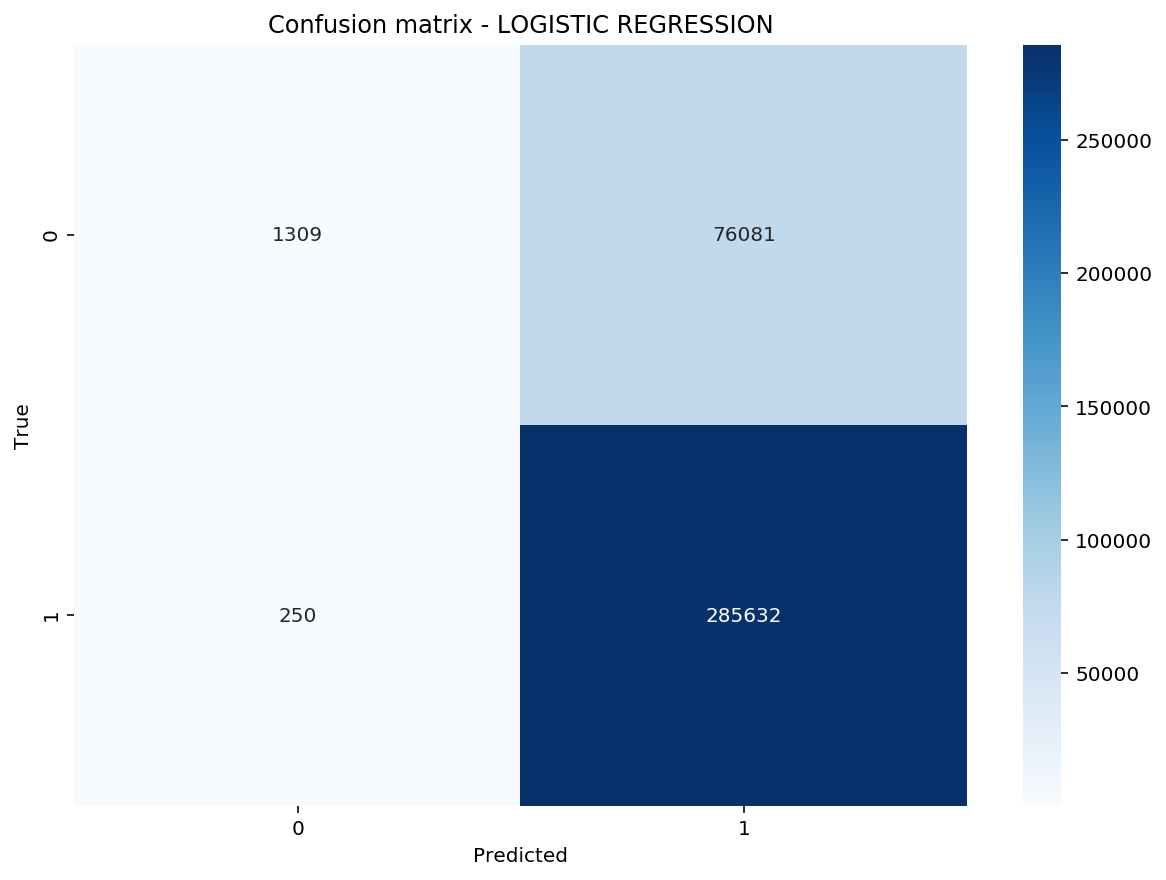

In [41]:
#Imprimimos la matriz de confusion para LOGISTIC REGRESSION
y_pred_test = model_LogReg.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test,y_pred_test), accuracy_score(y_test, y_pred_test))

In [23]:
data['classes'].value_counts(normalize=True)

1    0.786963
0    0.213037
Name: classes, dtype: float64

# 2. Modeling: Random Forest

In [33]:
model_RandForest = RandomForestClassifier(max_depth= 5, max_features= 5, n_estimators= 100)
model_RandForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
print(f'Random Forest train score: {model_RandForest.score(X_train, y_train)}')
print(f'Random Forest test score: {model_RandForest.score(X_test, y_test)}')

Random Forest train score: 0.9226010282739956
Random Forest test score: 0.9218574511660684


In [36]:
CrossValidation_score(model_RandForest)

Promedio CrossValidation_Score para Training: 0.9232180403941858
Promedio CrossValidation_Score para Testing:: 0.920877469932865


In [45]:
metricas(model_RandForest)

Se obtuvo un -> Accuracy score: 92.19%
Se obtuvo un -> Recall score: 100.00%
Se obtuvo un -> Precision score: 90.97%
Se obtuvo un -> Specificity score: 63.32%
Se obtuvo un -> F1 score: 95.27%


,Predicted Failure,Predicted Success
Actual Failure,49004,28386
Actual Success,1,285881


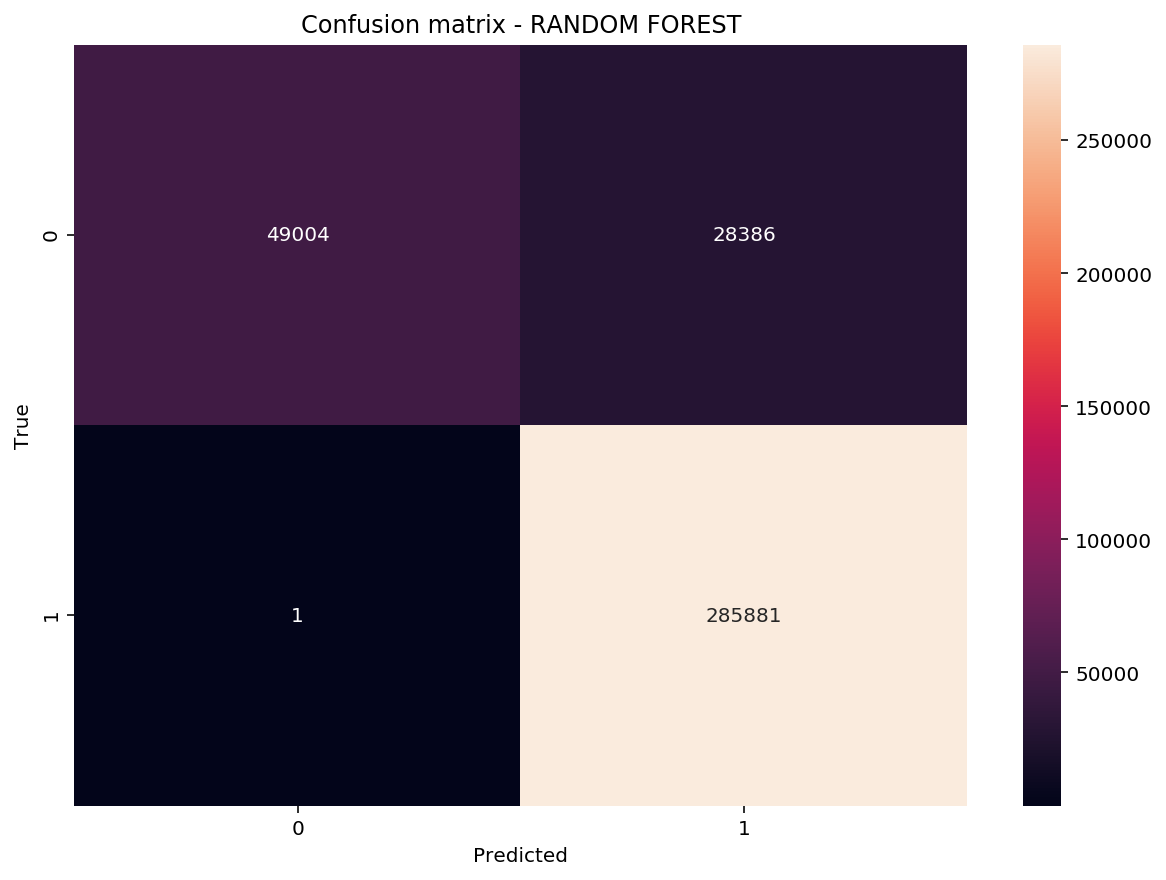

In [44]:
#Imprimimos la matriz de confusion para RANDOM FOREST
y_pred_test = model_RandForest.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test,y_pred_test), accuracy_score(y_test, y_pred_test))

In [38]:
feature_importance = pd.Series(data = model_RandForest.feature_importances_, index = X.columns)
feature_importance.sort_values(ascending = False)

recoveries                                  0.174473
recoveries*collection_recovery_fee          0.146587
collection_recovery_fee                     0.142857
last_fico_range_high*last_fico_range_low    0.136525
last_fico_range_low                         0.106218
                                              ...   
addr_state_VA                               0.000000
addr_state_DE                               0.000000
addr_state_FL                               0.000000
addr_state_HI                               0.000000
addr_state_VT                               0.000000
Length: 155, dtype: float64

# 3. Modeling: XGBoost

In [47]:
model_Xgb = XGBClassifier()
model_Xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
print(f'XGBoost Train score: {model_Xgb.score(X_train, y_train)}')
print(f'XGBoost Test score: {model_Xgb.score(X_test, y_test)}')

XGBoost Train score: 0.9848979630359329
XGBoost Test score: 0.9822254398907706


In [41]:
CrossValidation_score(model_Xgb)

Promedio CrossValidation_Score para Training: 0.9823072223279834
Promedio CrossValidation_Score para Testing:: 0.9814161275433524


In [50]:
metricas(model_Xgb)

Se obtuvo un -> Accuracy score: 98.22%
Se obtuvo un -> Recall score: 99.10%
Se obtuvo un -> Precision score: 98.65%
Se obtuvo un -> Specificity score: 94.99%
Se obtuvo un -> F1 score: 98.87%


,Predicted Failure,Predicted Success
Actual Failure,73511,3879
Actual Success,2578,283304


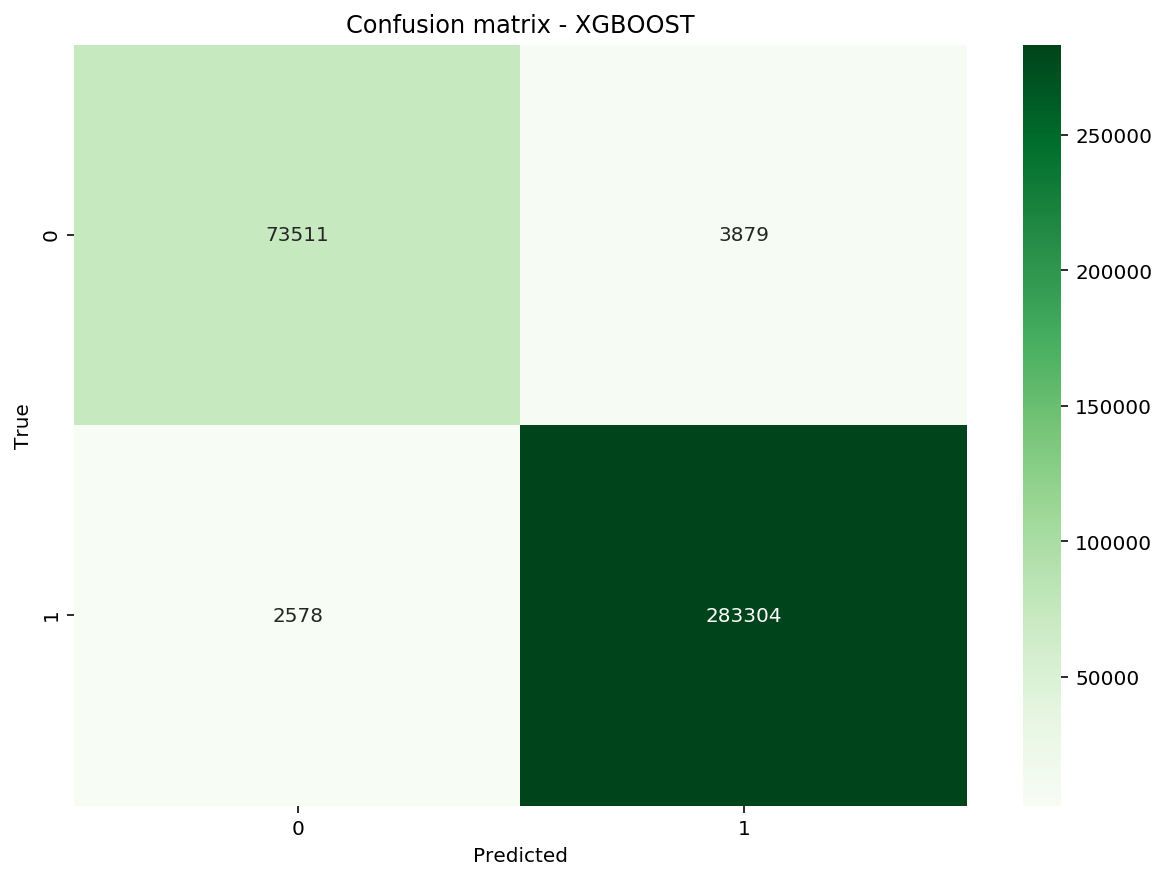

In [51]:
#Imprimimos la matriz de confusion para XGBOOST
y_pred_test = model_Xgb.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test,y_pred_test), accuracy_score(y_test, y_pred_test))

# 4. Modeling LigthGBM

In [52]:
#Usaremos estos hiperparámetros más usados y con mejor performance
model_LGBM=lgbm.LGBMClassifier(n_estimators=400,max_depth=6,learning_rate=0.1,verbose=0)
model_LGBM.fit(X_train,y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.374641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=0)

In [53]:
print(f'LigthGBM Train score: {model_LGBM.score(X_train, y_train)}')
print(f'LigthGBM Test score: {model_LGBM.score(X_test, y_test)}')

LigthGBM Train score: 0.9840367422731982
LigthGBM Test score: 0.981405117928164


In [47]:
CrossValidation_score(model_LGBM)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with p

In [48]:
metricas(model_LGBM)

Se obtuvo un -> Accuracy score: 98.14%
Se obtuvo un -> Recall score: 99.00%
Se obtuvo un -> Precision score: 98.64%
Se obtuvo un -> Specificity score: 94.95%
Se obtuvo un -> F1 score: 98.82%


,Predicted Failure,Predicted Success
Actual Failure,73485,3905
Actual Success,2850,283032


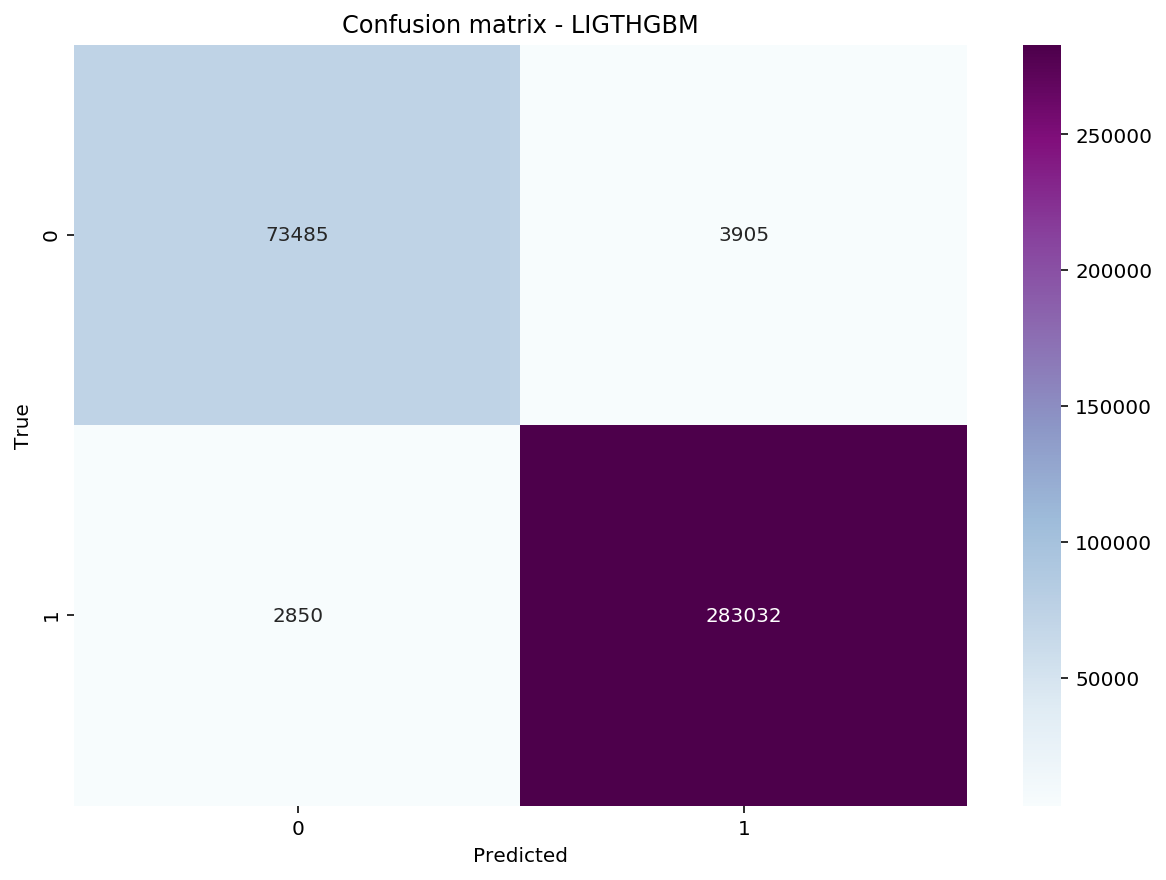

In [57]:
#Imprimimos la matriz de confusion para LigthGBM
y_pred_test = model_LGBM.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test,y_pred_test), accuracy_score(y_test, y_pred_test))

# 5. Modeling CatBoost

In [58]:
#from catboost import CatBoostClassifier
model_CatBst=CatBoostClassifier(n_estimators=500,verbose=0,max_depth=6)
model_CatBst.fit(X_train,y_train)

In [59]:
print(f'CatBoost Train score: {model_CatBst.score(X_train, y_train)}')
print(f'CatBoost Test score: {model_CatBst.score(X_test, y_test)}')

CatBoost Train score: 0.9850985212957479
CatBoost Test score: 0.9830732894360149


In [51]:
CrossValidation_score(model_CatBst)

Promedio CrossValidation_Score para Training: 0.9828180561691642
Promedio CrossValidation_Score para Testing:: 0.981919883146767


In [61]:
metricas(model_CatBst)

Se obtuvo un -> Accuracy score: 98.31%
Se obtuvo un -> Recall score: 99.18%
Se obtuvo un -> Precision score: 98.67%
Se obtuvo un -> Specificity score: 95.08%
Se obtuvo un -> F1 score: 98.93%


,Predicted Failure,Predicted Success
Actual Failure,73579,3811
Actual Success,2338,283544


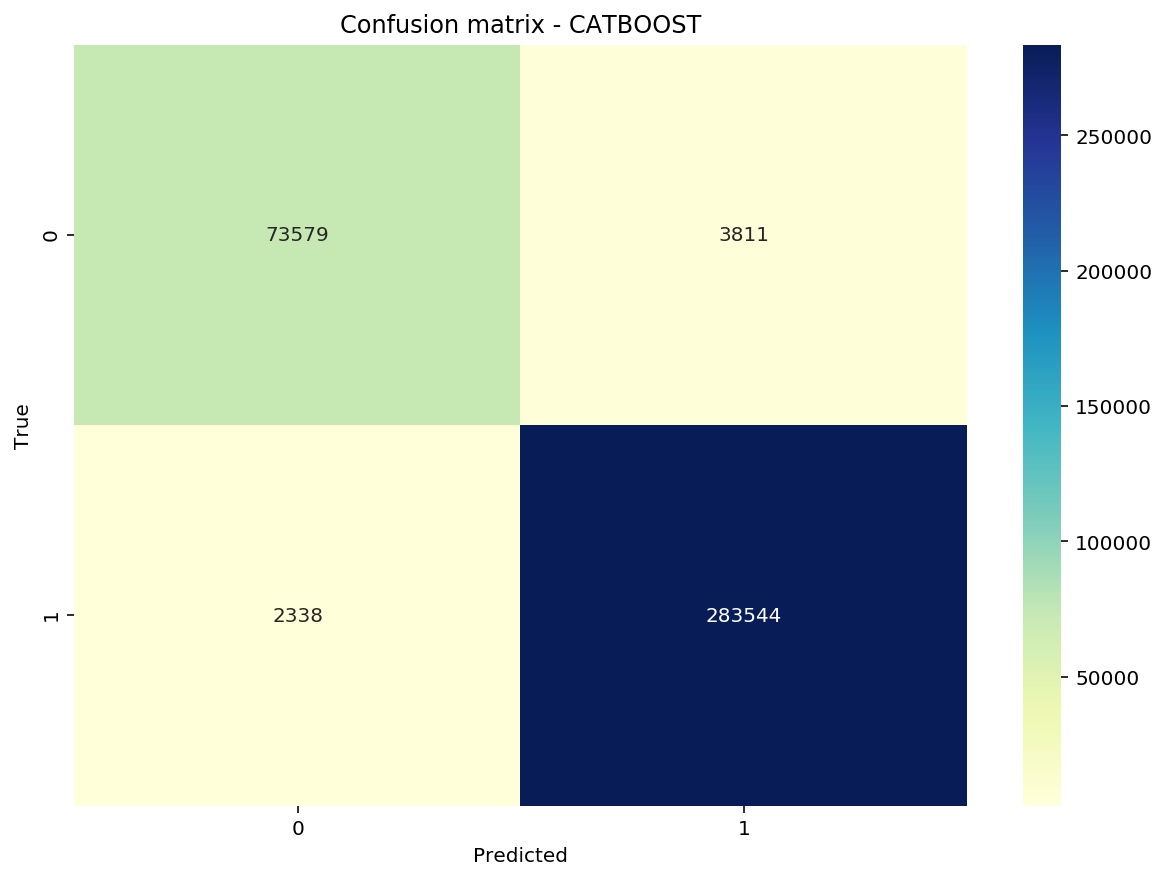

In [62]:
#Imprimimos la matriz de confusion para CatBoost
y_pred_test = model_CatBst.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test,y_pred_test), accuracy_score(y_test, y_pred_test))

# 6. Modeling Ensemble

In [64]:
from sklearn.ensemble import VotingClassifier

# Ya se tiene todos los modelos entrenados, entonces ahora realizaremos el entrenamiento por Ensamble de los modelos:
# Model_LogReg, model_RandForest, model_Xgb, model_LGBM, model_CatBst
model_Ensamble = VotingClassifier(estimators=[('lgr', model_LogReg), ('rf', model_RandForest), ('xgb', model_Xgb), 
                                    ('lgbm', model_LGBM), ('cbst', model_CatBst)],
                        voting='soft', weights=[1, 1, 3, 3, 3])

model_Ensamble.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

VotingClassifier(estimators=[('lgr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=No...
                                        

In [65]:
print(f'Ensemble Train score: {model_Ensamble.score(X_train, y_train)}')
print(f'Ensemble Test score: {model_Ensamble.score(X_test, y_test)}')

Ensemble Train score: 0.9849805458487979
Ensemble Test score: 0.9829301460062984


In [58]:
CrossValidation_score(model_Ensamble)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [66]:
metricas(model_Ensamble)

Se obtuvo un -> Accuracy score: 98.29%
Se obtuvo un -> Recall score: 99.27%
Se obtuvo un -> Precision score: 98.58%
Se obtuvo un -> Specificity score: 94.7%
Se obtuvo un -> F1 score: 98.92%


,Predicted Failure,Predicted Success
Actual Failure,73290,4100
Actual Success,2101,283781


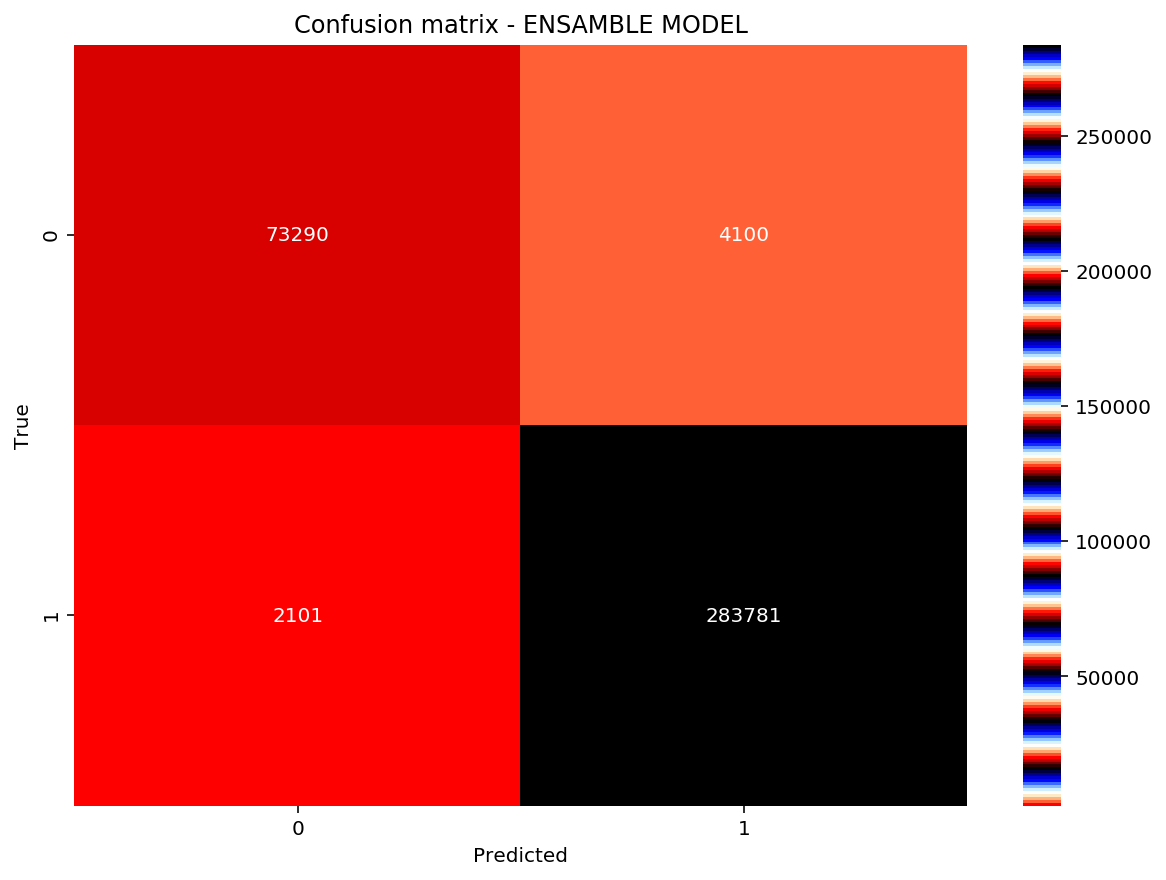

In [67]:
#Imprimimos la matriz de confusion para Ensambel Model
y_pred_test = model_Ensamble.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test,y_pred_test), accuracy_score(y_test, y_pred_test))

# 7. Modeling Neural Network

In [68]:
# Definimos el modelo keras
model_ann = Sequential()
model_ann.add(Dense(256, input_dim=155, activation= 'relu'))
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(4, activation ='relu'))
model_ann.add(Dense(1, activation='sigmoid'))

# Compilamos el modelo
model_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo
model_ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=5)

Train on 847634 samples, validate on 363272 samples
Epoch 1/10
847634/847634 [==============================] - 195s 230us/step - loss: 1438.3144 - accuracy: 0.7869 - val_loss: 0.5180 - val_accuracy: 0.7870
Epoch 2/10
847634/847634 [==============================] - 197s 233us/step - loss: 0.5180 - accuracy: 0.7870 - val_loss: 0.5180 - val_accuracy: 0.7870
Epoch 3/10
847634/847634 [==============================] - 195s 230us/step - loss: 0.5180 - accuracy: 0.7870 - val_loss: 0.5180 - val_accuracy: 0.7870
Epoch 4/10
847634/847634 [==============================] - 196s 232us/step - loss: 0.5180 - accuracy: 0.7870 - val_loss: 0.5182 - val_accuracy: 0.7870
Epoch 5/10
847634/847634 [==============================] - 199s 235us/step - loss: 0.5180 - accuracy: 0.7870 - val_loss: 0.5180 - val_accuracy: 0.7870
Epoch 6/10
847634/847634 [==============================] - 196s 231us/step - loss: 0.5180 - accuracy: 0.7870 - val_loss: 0.5180 - val_accuracy: 0.7870
Epoch 7/10
847634/847634 [=======

In [81]:
#evaluamos el modelo de redes neuronales
_,train_score = model_ann.evaluate(X_train, y_train)
_,test_score = model_ann.evaluate(X_test, y_test)

print('ANN Train score: %.2f' %(train_score*100))
print('ANN Test score: %.2f' %(test_score*100))

363272/363272 [==============================] - 4s 10us/step
ANN Train score: 78.70
ANN Test score: 78.70


In [87]:
# y_train_pred = model_ann.predict(X_train)
# y_test_pred = model_ann.predict(X_test)

# print_score(y_train, y_train_pred.round(), train=True)
# print_score(y_test, y_test_pred.round(), train=False)

In [84]:
#Compararemos los Accuracy de cada modelo para formarlo como un dataaset
acc_logReg = round(model_LogReg.score(X_train, y_train) * 100, 2)
acc_RandomForest = round(model_RandForest.score(X_train, y_train) * 100, 2)
acc_XGB = round(model_Xgb.score(X_train, y_train) * 100, 2)
acc_LGBM = round(model_LGBM.score(X_train, y_train) * 100, 2)
acc_CatBoost = round(model_CatBst.score(X_train, y_train) * 100, 2)
acc_Ensemble = round(model_Ensamble.score(X_train, y_train) * 100, 2)


In [95]:
acc_ANN= train_score*100
##### ---------------------------------------------------------- 

Resultado_Models = pd.DataFrame({
    'Modelos': ['Logistic Regression', 'Random Forest', 
              'XGBoost', 'LigthGBM', 'CatBoost',
              'Artificial Neural Network', 'Ensemble Models'],
    'Score': [acc_logReg,  acc_RandomForest, 
              acc_XGB, acc_LGBM, acc_CatBoost, acc_ANN,
              acc_Ensemble]})

Resultado_Models_df = Resultado_Models.sort_values(by='Score', ascending=False)
#Resultado_Models_df = Resultado_Models_df.set_index('Score')
Resultado_Models_df = Resultado_Models_df.reset_index(drop=True)
Resultado_Models_df.index = np.arange(1,len(Resultado_Models_df)+1)
Resultado_Models_df.head(8)

,Modelos,Score
1,CatBoost,98.510000
2,Ensemble Models,98.500000
3,XGBoost,98.490000
4,LigthGBM,98.400000
5,Random Forest,92.260000
6,Logistic Regression,78.980000
7,Artificial Neural Network,78.696227


## Fuentes:

Para el desarrolllo del presente proyecto y tomandolos como baseline, se ha revisado algunos autores para poder obtener una idea general de la problemática y como lo abarcan. Estos autores son los siguientes: 
- [Rajat Agrawal](https://github.com/ragraw26/Machine-Learning-Loan-Lending-Club), [Yiuhyuk](https://github.com/yiuhyuk/Project_3_Metis_Final), [Fares Sayah](https://www.kaggle.com/faressayah/lending-club-loan-defaulters-prediction)
- [Pavlo Fesenko](https://www.kaggle.com/pavlofesenko/minimizing-risks-for-loan-investments), [NamK](https://www.kaggle.com/namk134874/lending-club-data-exploration-and-modeling), [Maciej Biesek](https://github.com/maciejbiesek/Kaggle-Lending-Club-Loan-Data)
- [Alex Husted](https://github.com/jalexander03/100119-Lending-Club-Loan-Data), [Jonathan Reynolds](https://github.com/jreynolds999/LendingClub-Loan-Data), [Madhava Chandra](https://github.com/chanmad/Lending-Club--Default-Prediction)
- [Niko Ganev](https://github.com/ganevniko/LendingClub-Credit-Risk-Analysis), [Rohini Mandge](https://github.com/Rohini2505/Lending-Club-Loan-Analysis), [Joe Corliss](https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data/notebook), [Ty Mick](https://www.kaggle.com/tywmick/building-a-neural-network-to-predict-loan-risk)